In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
def drop_id(ds):
    return ds.drop(columns='Id')


def drop_nans(train, threshold):
    new_train = train.copy()
    
    for feature in new_train.columns:
        nans = new_train[feature].isnull().sum()
        if (nans / train.shape[0] > threshold):
            new_train = new_train.drop(columns=feature)    
            
    return new_train


def fillna(X):
    zero_nan_cols = ['GarageArea', 'GarageCars', "MasVnrArea", 'BsmtFinSF1', 'BsmtFinSF2',
                         'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr',
                         "1stFlrSF", "2ndFlrSF"]

    for col in zero_nan_cols:
        X[col] = X[col].fillna(0)

    X['Functional'] = X['Functional'].fillna("Typ")
    X['Electrical'] = X['Electrical'].fillna("SBrkr")
    X['KitchenQual'] = X['KitchenQual'].fillna("TA")

    for col in X.columns:
        if X[col].dtype == "object":
            X[col] = X[col].fillna("None")
            X[col] = X[col].astype("object")


def replace_nans(train):
    num_candidates = list(train.dtypes[train.dtypes != 'object'].index.values)
    train[num_candidates] = SimpleImputer().fit_transform(train[num_candidates])
    fillna(train)


def encode_features(train):
    new_train = train.copy()
    l_encoder = LabelEncoder()
    
    for feature in new_train.columns[:-1]:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = l_encoder.fit_transform(new_train[feature])
            
    return new_train

# Data preprocessing

In [3]:
train = pd.read_csv('data/train.csv')

train = train.drop_duplicates()
train = drop_id(train)
train = drop_nans(train, threshold=0.6)
replace_nans(train)

print("nan count: ", train.isnull().sum().max())

train = encode_features(train)
train

nan count:  0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,3,65.0,8450.0,1,3,3,0,4,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,8,4,208500.0
1,20.0,3,80.0,9600.0,1,3,3,0,2,0,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,8,4,181500.0
2,60.0,3,68.0,11250.0,1,0,3,0,4,0,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,8,4,223500.0
3,70.0,3,60.0,9550.0,1,0,3,0,0,0,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,8,0,140000.0
4,60.0,3,84.0,14260.0,1,0,3,0,2,0,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,3,62.0,7917.0,1,3,3,0,4,0,...,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,8,4,175000.0
1456,20.0,3,85.0,13175.0,1,3,3,0,4,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,8,4,210000.0
1457,70.0,3,66.0,9042.0,1,3,3,0,4,0,...,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,8,4,266500.0
1458,20.0,3,68.0,9717.0,1,3,3,0,4,0,...,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,8,4,142125.0


In [30]:
y_train = np.log(train['SalePrice'])
x_train = train.drop(columns='SalePrice')

cat_features = np.where(x_train.loc[:, x_train.columns.values].dtypes == "object")[0]

y_train = y_train.values
x_train = x_train.values

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

# XGBoost

In [36]:
params = {
    "learning_rate": uniform(1e-2,  1e-1),
    "max_depth": randint(1, 100),
    "min_child_weight": randint(1, 15),
    "n_estimators": randint(1, 1000),
    "colsample_bytree": uniform(1e-1,  1),
    "reg_lambda": uniform(0, 5),
    "reg_alpha": uniform(0, 1)
}

model = XGBRegressor()
gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train, y_train)
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'colsample_bytree': 0.4608407050090908, 'learning_rate': 0.07389470462638911, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 493, 'reg_alpha': 0.7957483511585762, 'reg_lambda': 0.4994939992710672}


In [37]:
model = XGBRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(model.predict(X_test), y_test)))

mean_squared_error:  0.12853587991161475


In [73]:
params = {
    "learning_rate": uniform(1e-2,  1e-1),
    "max_depth": randint(1, 100),
    "min_child_weight": randint(1, 15),
    "n_estimators": randint(1, 2000),
    "colsample_bytree": uniform(1e-1,  1),
    "reg_lambda": uniform(0, 5),
    "reg_alpha": uniform(0, 5)
}

model = XGBRegressor()
gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train, y_train)
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'colsample_bytree': 0.738429156342322, 'learning_rate': 0.09794623436814139, 'max_depth': 91, 'min_child_weight': 12, 'n_estimators': 1732, 'reg_alpha': 1.7542845071695075, 'reg_lambda': 1.241350621194845}


In [74]:
model = XGBRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(model.predict(X_test), y_test)))

mean_squared_error:  0.13905297470235262


# catboost

In [31]:
model = CatBoostRegressor(random_seed=0,
                          logging_level='Silent',
                          cat_features=cat_features)

params = {
    "n_estimators": randint(1, 400),
    "learning_rate": uniform(1e-3,  1e-1),
    "depth": randint(1, 15),
    "l2_leaf_reg": uniform(0, 1)
}

gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'depth': 2, 'l2_leaf_reg': 0.45999282878601455, 'learning_rate': 0.05744301872704567, 'n_estimators': 366}


In [32]:
model = CatBoostRegressor(**gs_model.best_params_, logging_level='Silent')
model.fit(X_train, y_train)
print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(model.predict(X_test), y_test)))

mean_squared_error:  0.13893975317371465


# lightgbm

In [33]:
model = LGBMRegressor()

params = {
    'num_leaves': randint(1, 3000),
    'learning_rate': uniform(1e-3,  1e-1),
    'max_depth': randint(1, 3000),
    'n_estimators': randint(1, 5000)
}

gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train, y_train)
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.06806705291332416, 'max_depth': 1745, 'n_estimators': 894, 'num_leaves': 1209}


In [34]:
model = LGBMRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(model.predict(X_test), y_test)))

mean_squared_error:  0.14358585580016084


# skilearn.RandomForest

In [8]:
# перебрать еще параметры, н-р кол-во деревьев
params = {
    "max_depth": randint(1, 3000),
    "n_estimators": randint(1, 5000),
    "min_samples_split":  randint(1, 15)
}

model = RandomForestRegressor()
gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"best params: {gs_model.best_params_}")

best params: {'max_depth': 436, 'min_samples_split': 2, 'n_estimators': 3364}


In [9]:
model = RandomForestRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_error: ", np.sqrt(metrics.mean_squared_error(model.predict(X_test), y_test)))

mean_squared_log_error:  0.15273818226281224


<Figure size 1296x576 with 0 Axes>

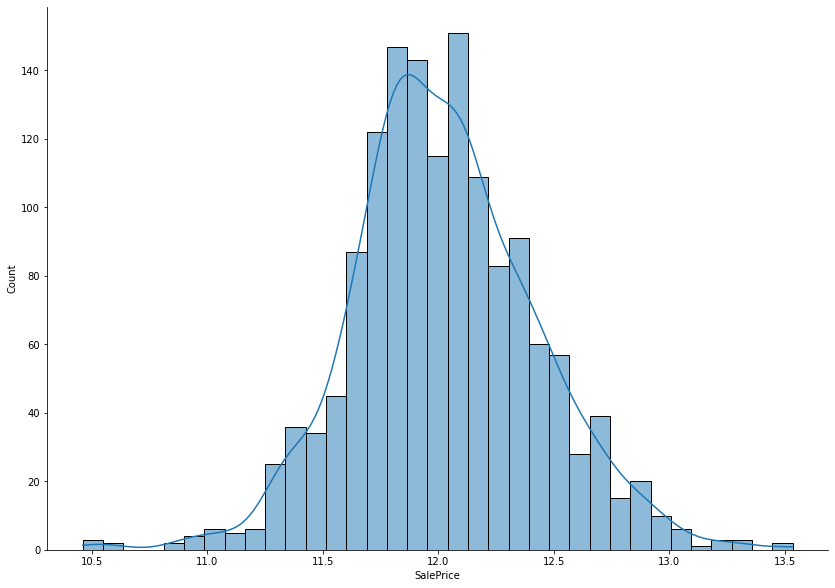

In [4]:
plt.figure(figsize=(18, 8))
sns.displot(np.log(train['SalePrice']), kde=True, height=8.27, aspect=11.7/8.27)

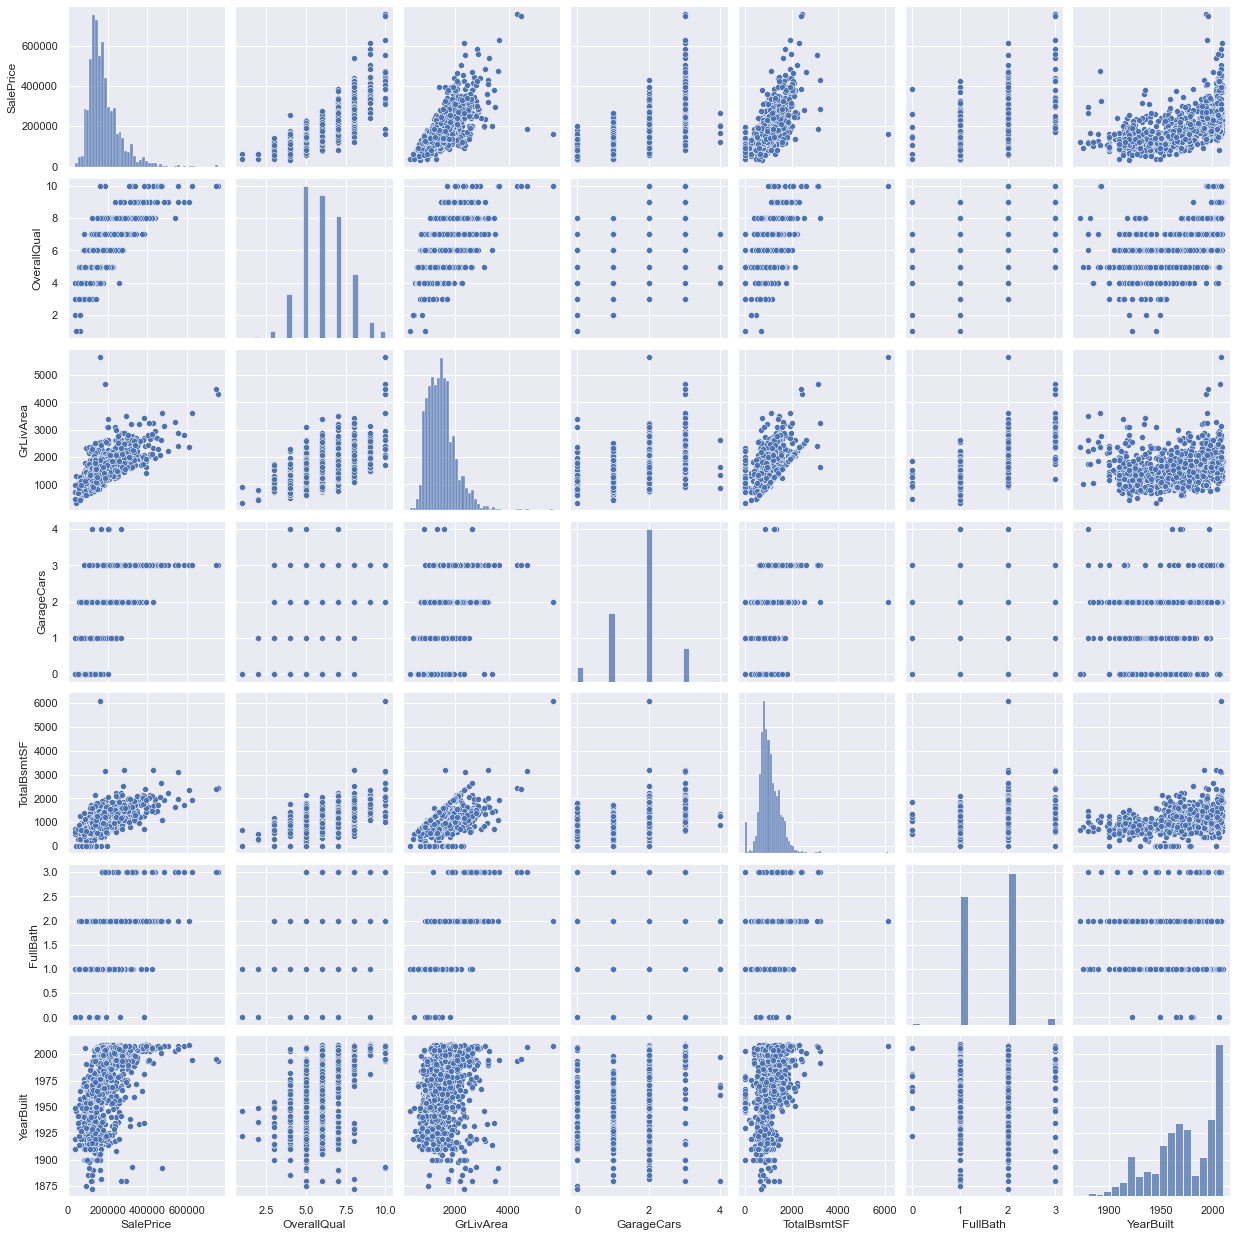

In [5]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();